In [ ]:
# Installs
!pip install folium

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker 
import folium
from datetime import datetime, timedelta,date
from scipy.interpolate import make_interp_spline, BSpline
import plotly.express as px
import json, requests

In [27]:
india_data_json = requests.get('https://api.rootnet.in/covid19-in/unofficial/covid19india.org/statewise').json()
df_india = pd.io.json.json_normalize(india_data_json['data']['statewise'])
df_india = df_india.set_index("state")

In [28]:
df_india=df_india.drop(index="State Unassigned",axis=0)
df_india

,confirmed,recovered,deaths,active
state,,,,
Maharashtra,1648665,1470660,43348,134137
Andhra Pradesh,808924,773548,6606,28770
Karnataka,805947,719558,10947,75423
Tamil Nadu,711713,671489,10956,29268
Uttar Pradesh,472068,438512,6902,26654
Delhi,359488,327390,6312,25786
Kerala,397218,302017,1353,93745
West Bengal,353822,310086,6546,37190
Odisha,282695,266105,1312,15278


In [29]:
total = df_india.sum()
total

confirmed    7945975
recovered    7198877
deaths        119538
active        626192
dtype: int64

In [30]:
total = df_india.sum()
total.name = "Total"
df_t = pd.DataFrame(total,dtype=float).transpose()
df_t["Mortality Rate (per 100)"] = np.round(100*df_t["deaths"]/df_t["confirmed"],4)
df_t.style.background_gradient(cmap='Purples',axis=1)

,confirmed,recovered,deaths,active,Mortality Rate (per 100)
Total,7.94598e+06,7.19888e+06,119538,626192,1.5044


### States with Reported Deaths

In [31]:
df_india["Mortality Rate (per 100)"]= np.round(np.nan_to_num(100*df_india["deaths"]/df_india["confirmed"]),4)
df_india[:].style.background_gradient(cmap='Blues',subset=["confirmed"])\
                        .background_gradient(cmap='Reds',subset=["deaths"])\
                        .background_gradient(cmap='Greens',subset=["recovered"])\
                        .background_gradient(cmap='Purples',subset=["active"])\
                        .background_gradient(cmap='YlOrBr',subset=["Mortality Rate (per 100)"])\
                        .format("{:.2f}",subset=["Mortality Rate (per 100)"])

,confirmed,recovered,deaths,active,Mortality Rate (per 100)
state,,,,,
Maharashtra,1648665,1470660,43348,134137,2.63
Andhra Pradesh,808924,773548,6606,28770,0.82
Karnataka,805947,719558,10947,75423,1.36
Tamil Nadu,711713,671489,10956,29268,1.54
Uttar Pradesh,472068,438512,6902,26654,1.46
Delhi,359488,327390,6312,25786,1.76
Kerala,397218,302017,1353,93745,0.34
West Bengal,353822,310086,6546,37190,1.85
Odisha,282695,266105,1312,15278,0.46


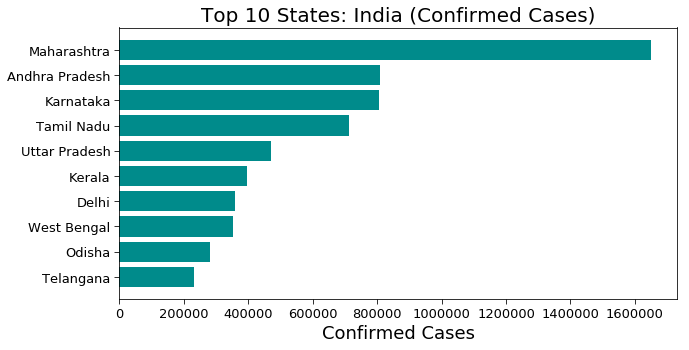

In [32]:
f = plt.figure(figsize=(10,5))
plt.barh(df_india.sort_values('confirmed')["confirmed"].index[-10:],df_india.sort_values('confirmed')["confirmed"].values[-10:],color="darkcyan")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Confirmed Cases",fontsize=18)
plt.title("Top 10 States: India (Confirmed Cases)",fontsize=20)
plt.savefig('Top 10 States_India (Confirmed Cases).png')

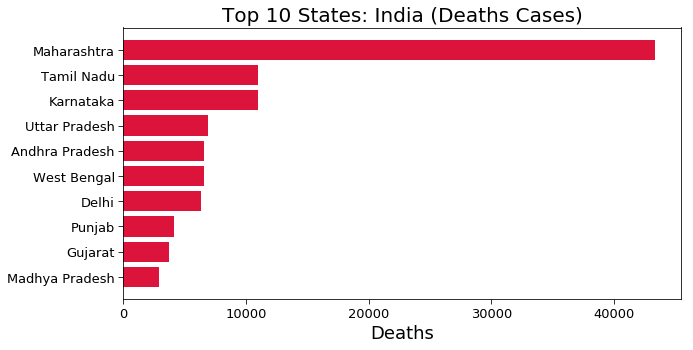

In [33]:
f = plt.figure(figsize=(10,5))
plt.barh(df_india.sort_values('deaths')["deaths"].index[-10:],df_india.sort_values('deaths')["deaths"].values[-10:],color="crimson")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Deaths",fontsize=18)
plt.title("Top 10 States: India (Deaths Cases)",fontsize=20)
plt.savefig('Top 10 States_India (Deaths Cases).png')

## Map Visualization (Statewise India)
<hr>

In [34]:
# Adding Location data (Latitude,Longitude)
locations = {
    "Kerala" : [10.8505,76.2711],
    "Maharashtra" : [19.7515,75.7139],
    "Karnataka": [15.3173,75.7139],
    "Telangana": [18.1124,79.0193],
    "Uttar Pradesh": [26.8467,80.9462],
    "Rajasthan": [27.0238,74.2179],
    "Gujarat":[22.2587,71.1924],
    "Delhi" : [28.7041,77.1025],
    "Punjab":[31.1471,75.3412],
    "Tamil Nadu": [11.1271,78.6569],
    "Haryana": [29.0588,76.0856],
    "Madhya Pradesh":[22.9734,78.6569],
    "Jammu and Kashmir":[33.7782,76.5762],
    "Ladakh": [34.1526,77.5770],
    "Andhra Pradesh":[15.9129,79.7400],
    "West Bengal": [22.9868,87.8550],
    "Bihar": [25.0961,85.3131],
    "Chhattisgarh":[21.2787,81.8661],
    "Chandigarh":[30.7333,76.7794],
    "Uttarakhand":[30.0668,79.0193],
    "Himachal Pradesh":[31.1048,77.1734],
    "Goa": [15.2993,74.1240],
    "Odisha":[20.9517,85.0985],
    "Andaman and Nicobar Islands": [11.7401,92.6586],
    "Puducherry":[11.9416,79.8083],
    "Manipur":[24.6637,93.9063],
    "Mizoram":[23.1645,92.9376],
    "Assam":[26.2006,92.9376],
    "Meghalaya":[25.4670,91.3662],
    "Tripura":[23.9408,91.9882],
    "Arunachal Pradesh":[28.2180,94.7278],
    "Jharkhand" : [23.6102,85.2799],
    "Nagaland": [26.1584,94.5624],
    "Sikkim": [27.5330,88.5122],
    "Dadra and Nagar Haveli and Daman and Diu":[20.1809,73.0169],
    "Lakshadweep":[10.5667,72.6417],
}
df_india["Lat"] = ""
df_india["Long"] = ""

for index in df_india.index :
    if index in locations:
        df_india.loc[df_india.index == index,"Lat"] = locations[index][0]
        df_india.loc[df_india.index == index,"Long"] = locations[index][1]
    else:
        df_india.drop([index])

In [35]:
df_india

,confirmed,recovered,deaths,active,Mortality Rate (per 100),Lat,Long
state,,,,,,,
Maharashtra,1648665,1470660,43348,134137,2.6293,19.7515,75.7139
Andhra Pradesh,808924,773548,6606,28770,0.8166,15.9129,79.74
Karnataka,805947,719558,10947,75423,1.3583,15.3173,75.7139
Tamil Nadu,711713,671489,10956,29268,1.5394,11.1271,78.6569
Uttar Pradesh,472068,438512,6902,26654,1.4621,26.8467,80.9462
Delhi,359488,327390,6312,25786,1.7558,28.7041,77.1025
Kerala,397218,302017,1353,93745,0.3406,10.8505,76.2711
West Bengal,353822,310086,6546,37190,1.8501,22.9868,87.855
Odisha,282695,266105,1312,15278,0.4641,20.9517,85.0985


In [36]:
india = folium.Map(location=[23,80],zoom_start=4,max_zoom=6,min_zoom=4,height=500,width="80%")
for i in range(0,len(df_india[df_india['confirmed']>=0])):
    folium.Circle(
        location=[df_india.iloc[i]['Lat'], df_india.iloc[i]['Long']],
        tooltip = "<h5 style='text-align:center;font-weight: bold'>"+df_india.iloc[i].name+"</h5>"+
        "<li>Confirmed: "+str(df_india.iloc[i]['confirmed'])+"</li>"+
        "<li>Active:   "+str(df_india.iloc[i]['active'])+"</li>"+
        "<li>Recovered:   "+str(df_india.iloc[i]['recovered'])+"</li>"+
        "<li>Deaths:   "+str(df_india.iloc[i]['deaths'])+"</li>"+
        "<li>Mortality Rate:   "+str(np.round(df_india.iloc[i]['Mortality Rate (per 100)'],2))+"</li>"
        ,
        radius=(int(np.log2(df_india.iloc[i]['confirmed']+0.2)))*15000,
        color='#ff6600',
        fill_color='#ff8533').add_to(india)

india       #function call 